In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# clustering
from sklearn.cluster import KMeans

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# feature selection for regression models
from sklearn.feature_selection import mutual_info_regression

# feature selection for classification models
from boruta import BorutaPy
from sklearn.feature_selection import RFECV

# model evaluation for regression models
from sklearn.metrics import mean_squared_error

# model evaluation for classification models
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#arm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# time series (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# EDA

Selection of features from datasets

In [2]:
cases_state_df = pd.read_csv('covid19-public-main/epidemic/cases_state.csv')
cases_state_df = cases_state_df[['date','state','cases_new','cases_recovered']]
cases_state_df.head(16)

,date,state,cases_new,cases_recovered
0,2020-01-25,Johor,4,0
1,2020-01-25,Kedah,0,0
2,2020-01-25,Kelantan,0,0
3,2020-01-25,Melaka,0,0
4,2020-01-25,Negeri Sembilan,0,0
5,2020-01-25,Pahang,0,0
6,2020-01-25,Perak,0,0
7,2020-01-25,Perlis,0,0
8,2020-01-25,Pulau Pinang,0,0
9,2020-01-25,Sabah,0,0


In [3]:
death_state_df = pd.read_csv('covid19-public-main/epidemic/deaths_state.csv')
death_state_df = death_state_df[['date','state','deaths_new']]
death_state_df.head(16)

,date,state,deaths_new
0,2020-03-17,Johor,1
1,2020-03-17,Kedah,0
2,2020-03-17,Kelantan,0
3,2020-03-17,Melaka,0
4,2020-03-17,Negeri Sembilan,0
5,2020-03-17,Pahang,0
6,2020-03-17,Perak,0
7,2020-03-17,Perlis,0
8,2020-03-17,Pulau Pinang,0
9,2020-03-17,Sabah,0


In [4]:
hospital_state_df = pd.read_csv('covid19-public-main/epidemic/hospital.csv')
hospital_state_df = hospital_state_df[['date','state','admitted_covid','discharged_covid']]
hospital_state_df.columns = ['date','state','hospital_admitted_covid','hospital_discharged_covid']
hospital_state_df.head(16)

,date,state,hospital_admitted_covid,hospital_discharged_covid
0,2020-03-24,Johor,0,0
1,2020-03-24,Kedah,0,0
2,2020-03-24,Kelantan,6,0
3,2020-03-24,Melaka,0,0
4,2020-03-24,Negeri Sembilan,0,0
5,2020-03-24,Pahang,0,0
6,2020-03-24,Perak,0,1
7,2020-03-24,Perlis,0,0
8,2020-03-24,Pulau Pinang,0,0
9,2020-03-24,Sabah,0,0


In [5]:
icu_state_df = pd.read_csv('covid19-public-main/epidemic/icu.csv')
icu_state_df = icu_state_df.copy()[['date','state','icu_covid','vent_covid']]
icu_state_df.columns = ['date','state','icu_covid','vent_covid']
icu_state_df.head(16)

,date,state,icu_covid,vent_covid
0,2020-03-24,Johor,0,0
1,2020-03-24,Kedah,2,1
2,2020-03-24,Kelantan,1,1
3,2020-03-24,Melaka,0,0
4,2020-03-24,Negeri Sembilan,0,0
5,2020-03-24,Pahang,2,1
6,2020-03-24,Perak,24,4
7,2020-03-24,Perlis,0,0
8,2020-03-24,Pulau Pinang,0,0
9,2020-03-24,Sabah,1,1


In [6]:
pkrc_state_df = pd.read_csv('covid19-public-main/epidemic/pkrc.csv')
pkrc_state_df = pkrc_state_df[['date','state','admitted_covid','discharge_covid','pkrc_covid']]
pkrc_state_df.columns = ['date','state','pkrc_admitted_covid','pkrc_discharged_covid','pkrc_covid']
pkrc_state_df.head(16)

,date,state,pkrc_admitted_covid,pkrc_discharged_covid,pkrc_covid
0,2020-03-28,Kelantan,0,0,0
1,2020-03-28,Perlis,0,0,8
2,2020-03-28,Pulau Pinang,0,0,13
3,2020-03-28,Sarawak,0,0,22
4,2020-03-28,Selangor,12,5,145
5,2020-03-28,W.P. Labuan,1,0,6
6,2020-03-29,Kelantan,0,0,0
7,2020-03-29,Perlis,0,0,8
8,2020-03-29,Pulau Pinang,0,0,11
9,2020-03-29,Sarawak,0,0,29


In [7]:
vax_state_df = pd.read_csv('citf-public-main/vaccination/vax_state.csv')
vax_state_df = vax_state_df[['date','state','daily','cumul_partial']]
vax_state_df.columns = ['date','state','daily_vaccination','cumul_vaccination']
vax_state_df.head(16)

,date,state,daily_vaccination,cumul_vaccination
0,2021-02-24,Johor,0,0
1,2021-02-24,Kedah,0,0
2,2021-02-24,Kelantan,0,0
3,2021-02-24,Melaka,0,0
4,2021-02-24,Negeri Sembilan,0,0
5,2021-02-24,Pahang,0,0
6,2021-02-24,Perak,0,0
7,2021-02-24,Perlis,0,0
8,2021-02-24,Pulau Pinang,0,0
9,2021-02-24,Sabah,0,0


In [21]:
population_df = pd.read_csv('covid19-public-main/static/population.csv')
population_df = population_df[['state','pop']]
population_df

,state,pop
0,Malaysia,32657400
1,Johor,3781000
2,Kedah,2185100
3,Kelantan,1906700
4,Melaka,932700
5,Negeri Sembilan,1128800
6,Pahang,1678700
7,Pulau Pinang,1773600
8,Perak,2510300
9,Perlis,254900


In [9]:
num = ['00','01','02','03','04']
positive_df = pd.DataFrame()

for n in num:
    df = pd.read_csv('covid19-public-main/epidemic/linelist/linelist_cases_'+n+'.csv',low_memory=False)
    positive_df = pd.concat([positive_df,df])

positive_df = positive_df[['import','cluster','symptomatic','state','district','age','male','malaysian']].copy()
# Remove negative age (unknown)
positive_df = positive_df[positive_df['age'] >= 0]
positive_df

,import,cluster,symptomatic,state,district,age,male,malaysian
3,1,0,1,1,2,40,1,0
4,1,0,0,1,2,34,0,0
5,1,0,1,1,2,52,1,0
6,1,0,1,2,17,4,0,0
7,1,0,1,1,2,49,0,0
...,...,...,...,...,...,...,...,...
277560,0,0,1,16,159,41,1,1
277561,0,0,1,16,159,28,1,1
277562,0,0,1,16,159,25,0,1
277563,0,0,1,16,159,23,0,1


In [10]:
death_df = pd.read_csv('covid19-public-main\epidemic\linelist\linelist_deaths.csv')
death_df = death_df[['date','state','age','male','bid','malaysian','comorb']]
death_df

,date,state,age,male,bid,malaysian,comorb
0,2020-03-17,Johor,34,1,0,1,1
1,2020-03-17,Sarawak,60,1,0,1,1
2,2020-03-20,Sabah,58,1,0,1,1
3,2020-03-21,Kelantan,69,1,0,1,1
4,2020-03-21,Melaka,50,1,0,1,1
...,...,...,...,...,...,...,...
26678,2021-10-03,Sarawak,83,1,0,1,1
26679,2021-10-03,Sarawak,79,0,0,1,1
26680,2021-10-03,Sarawak,39,0,1,1,1
26681,2021-10-03,Selangor,70,1,0,1,1


In [11]:
used_df = [cases_state_df.copy(),
           death_state_df.copy(),
           hospital_state_df.copy(),
           icu_state_df.copy(),
           pkrc_state_df.copy(),
           vax_state_df.copy(),
           population_df.copy(),
           positive_df.copy(),
           death_df.copy()]

used_df_name = ['Daily cases',
                'Daily death cases',
                'Hospital information',
                'ICU information',
                'PKRC information',
                'Vaccination information',
                'Population',
                'Positive cases',
                'Death']

total_states = ['Johor',
                'Kedah',
                'Kelantan',
                'Melaka',
                'Negeri Sembilan',
                'Pahang',
                'Perak',
                'Perlis',
                'Pulau Pinang',
                'Sabah',
                'Sarawak',
                'Selangor',
                'Terengganu',
                'W.P. Kuala Lumpur',
                'W.P. Labuan',
                'W.P. Putrajaya']

Checking data types

In [12]:
for i,df in enumerate(used_df):
    print(used_df_name[i])
    print(df.dtypes)
    print()

Daily cases
date               object
state              object
cases_new           int64
cases_recovered     int64
dtype: object

Daily death cases
date          object
state         object
deaths_new     int64
dtype: object

Hospital information
date                         object
state                        object
hospital_admitted_covid       int64
hospital_discharged_covid     int64
dtype: object

ICU information
date          object
state         object
icu_covid      int64
vent_covid     int64
dtype: object

PKRC information
date                     object
state                    object
pkrc_admitted_covid       int64
pkrc_discharged_covid     int64
pkrc_covid                int64
dtype: object

Vaccination information
date                 object
state                object
daily_vaccination     int64
cumul_vaccination     int64
dtype: object

Population
state    object
pop       int64
dtype: object

Positive cases
import         int64
cluster        int64
symptomatic    int64

In [13]:
for i,df in enumerate(used_df):
    print(used_df_name[i])
    print(df.isnull().sum())
    print()

Daily cases
date               0
state              0
cases_new          0
cases_recovered    0
dtype: int64

Daily death cases
date          0
state         0
deaths_new    0
dtype: int64

Hospital information
date                         0
state                        0
hospital_admitted_covid      0
hospital_discharged_covid    0
dtype: int64

ICU information
date          0
state         0
icu_covid     0
vent_covid    0
dtype: int64

PKRC information
date                     0
state                    0
pkrc_admitted_covid      0
pkrc_discharged_covid    0
pkrc_covid               0
dtype: int64

Vaccination information
date                 0
state                0
daily_vaccination    0
cumul_vaccination    0
dtype: int64

Population
state    0
pop      0
dtype: int64

Positive cases
import         0
cluster        0
symptomatic    0
state          0
district       0
age            0
male           0
malaysian      0
dtype: int64

Death
date         0
state        0
age          

Detection and removal of outliers (For continuous values)

In [14]:
def checking(df,name,feature=[]):
    length = len(feature)
    
    if length != 1:
        num = 100 + length*10 + 1

        plt.figure(figsize=(15,5))

        for f in feature:
            plt.subplot(num)
            print('Skewness:',df[f].skew(axis = 0))

            plt.scatter(df['date'], df[f])
            plt.title(f)
            plt.xticks([])
            num += 1
    else:
        plt.figure(figsize=(7,5))
        
        for f in feature:
            print('Skewness:',df[f].skew(axis = 0))

            plt.scatter(df['date'], df[f])
            plt.title(f)
            plt.xticks([])
        
    plt.tight_layout()
    plt.savefig('images/q2/EDA/distribution/before/'+name+'_before.png')
    plt.show()

Skewness: 6.167672988125625
Skewness: 6.461484727644976


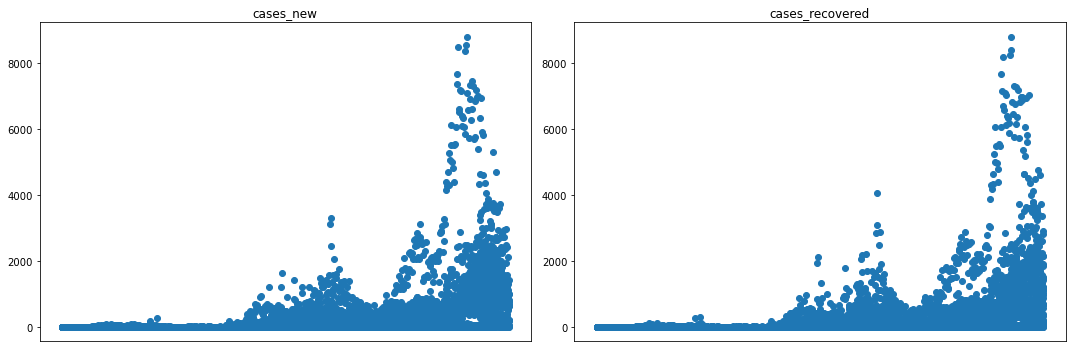

In [83]:
checking(cases_state_df.copy(),'Daily cases',['cases_new','cases_recovered'])

Skewness: 10.426310312625496


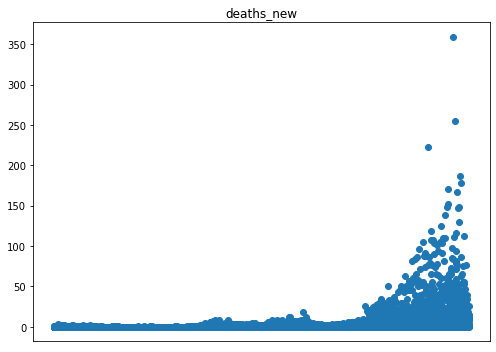

In [88]:
checking(death_state_df.copy(),'Daily death cases',['deaths_new']) # <200

Skewness: 3.429090193027212
Skewness: 3.7322797349655406


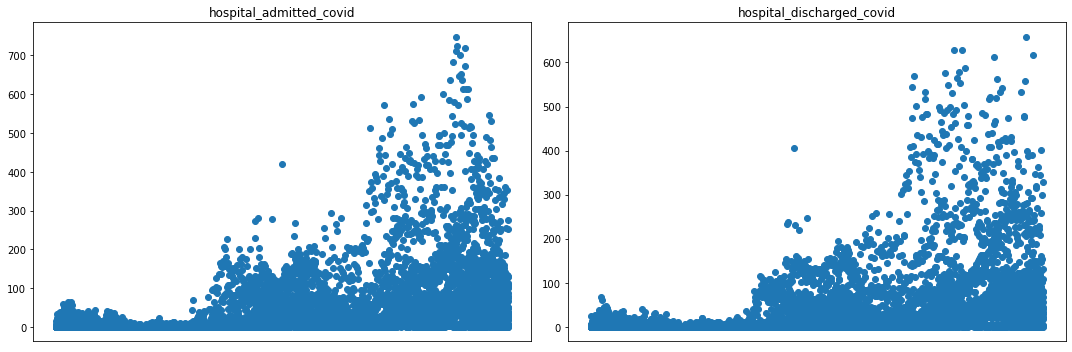

In [18]:
checking(hospital_state_df.copy(),'Hospital information',['hospital_admitted_covid','hospital_discharged_covid'])

Skewness: 3.902327058951386
Skewness: 4.108709569670289


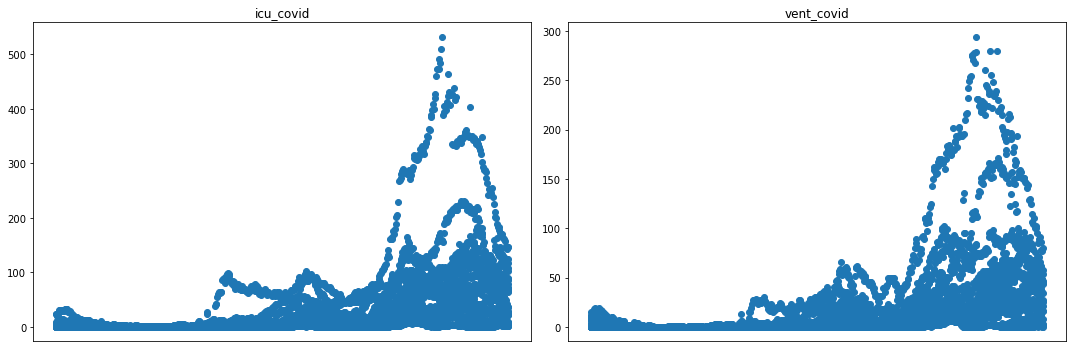

In [19]:
checking(icu_state_df.copy(),'ICU information',['icu_covid','vent_covid'])

Skewness: 3.8856730026593174
Skewness: 4.083183805144836
Skewness: 2.3311605555384243


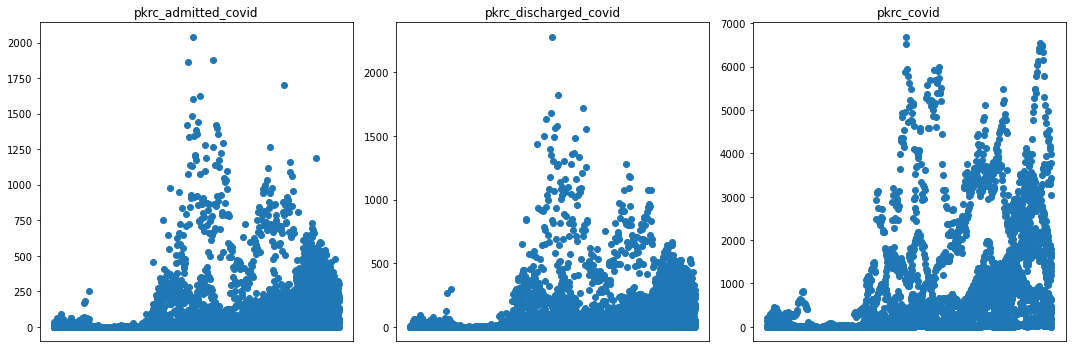

In [20]:
checking(pkrc_state_df.copy(),'PKRC information',['pkrc_admitted_covid','pkrc_discharged_covid','pkrc_covid']) # 2<2000

Skewness: 3.118317609964699


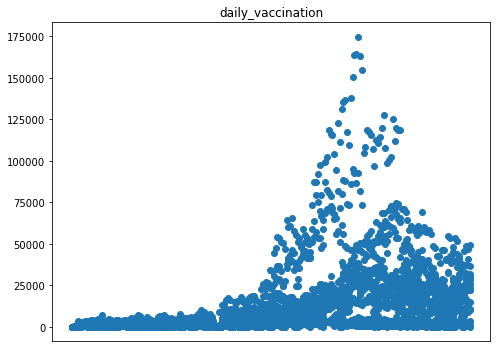

In [89]:
checking(vax_state_df.copy(),'Vaccination information',['daily_vaccination'])

In [15]:
def filtering(df,feature,limit):
    df_filtered = df[df[feature] <= limit]
    
    print('Number of data removed:',len(df)-len(df_filtered))
    print('Skewness after removed outliers:',df_filtered[feature].skew(axis = 0))
    
    plt.figure(figsize=(7,5))
    plt.scatter(df_filtered['date'], df_filtered[feature])
    plt.title(feature)
    plt.xticks([])
    
    plt.tight_layout()
    plt.savefig('images/q2/EDA/distribution/after/'+feature+'_after.png')
    plt.show()
    
    return df_filtered

Number of data removed: 3
Skewness after removed outliers: 7.760719747936899


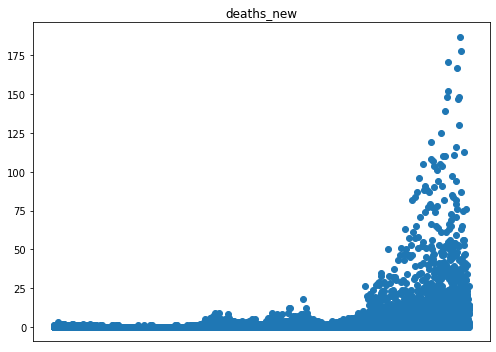

In [16]:
death_state_df = filtering(death_state_df.copy(),'deaths_new',200)

Number of data removed: 1
Skewness after removed outliers: 3.933180429226713


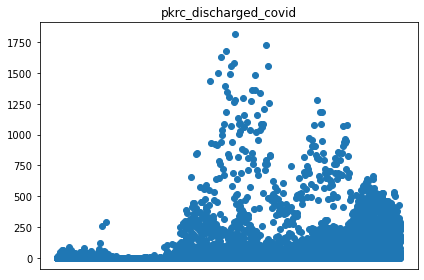

In [14]:
# Does not improve the skewness much, remain original dataframe
pkrc_state_df_unused = filtering(pkrc_state_df.copy(),'pkrc_discharged_covid',2000)

In [17]:
used_df = [cases_state_df.copy(),
           death_state_df.copy(),
           hospital_state_df.copy(),
           icu_state_df.copy(),
           pkrc_state_df.copy(),
           vax_state_df.copy(),
           population_df.copy(),
           positive_df.copy(),
           death_df.copy()]

Which gender are most susceptible to COVID-19?

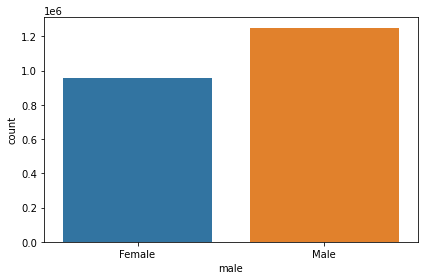

In [23]:
gender_plot = sns.countplot(x="male", data=positive_df)
gender_plot.set_xticklabels(['Female','Male'])
plt.tight_layout()
plt.savefig('images/q2/EDA/questions/gender_counts.png')
plt.show()

Distribution of death by gender & state

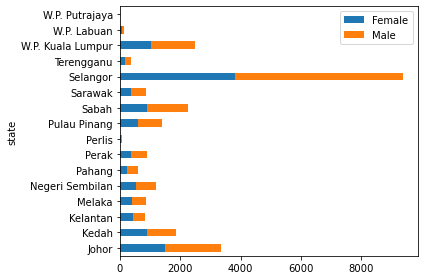

In [34]:
dist = death_df.groupby(['state', 'male'])['male'].count()
dist = dist.unstack('male')
dist.plot(kind='barh',stacked=True)
plt.legend(['Female','Male'])
plt.tight_layout()
plt.savefig('images/q2/EDA/questions/gender_state_distribution.png')
plt.show()

Any correlations between admitted and discharged of Covid-19 in hospital and PKRC?

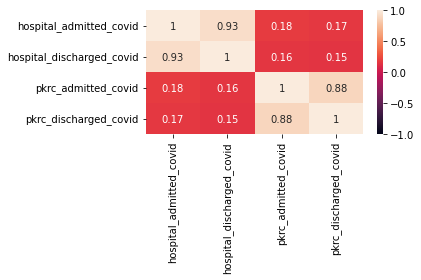

In [72]:
hospital = hospital_state_df[['date','hospital_admitted_covid','hospital_discharged_covid']]
pkrc = pkrc_state_df[['date','pkrc_admitted_covid','pkrc_discharged_covid']]
hospital_pkrc = hospital.merge(right=pkrc, how="inner")
sns.heatmap(hospital_pkrc.corr(),annot=True, vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig('images/q2/EDA/questions/hospital_pkrc_correlation.png')
plt.show()

# 1. Has vaccination helped reduce the daily cases? What states have shown the effect of vaccination?

In [26]:
def q1(vax_df,cases_df,state):
    print(state)
    print()
    
    vax = vax_df[vax_df['state'] == state]
    cases = cases_df[cases_df['state'] == state]
    
    vax_added = vax.copy()
    vax_added['effective_date'] = vax[['date']].shift(periods=-14)['date']
    vax_added.drop('date',axis=1,inplace=True)
    
    vax_added = vax_added[['effective_date','daily_vaccination']].copy()
    cases = cases[['date','cases_new']].copy()

    combine = vax_added.merge(right=cases, how="inner", left_on="effective_date", right_on="date")
    combine = combine[['date','daily_vaccination','cases_new']]
    display(combine)
    
    cor = combine.corr()
    sns.heatmap(cor, annot=True, vmin=-1, vmax=1)
    plt.title('Correlation of new cases and vaccination in '+state)

    plt.savefig('images/q2/1/'+state+'_heatmap.png')
    plt.show()

Johor



,date,daily_vaccination,cases_new
0,2021-03-10,0,273
1,2021-03-11,79,170
2,2021-03-12,0,135
3,2021-03-13,2,101
4,2021-03-14,827,121
...,...,...,...
199,2021-09-25,42688,1377
200,2021-09-26,42962,1455
201,2021-09-27,38553,1226
202,2021-09-28,46373,1319


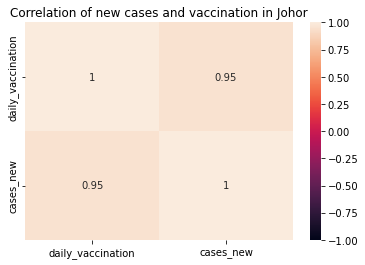

Kedah



,date,daily_vaccination,cases_new
0,2021-03-10,0,20
1,2021-03-11,0,18
2,2021-03-12,6,23
3,2021-03-13,38,13
4,2021-03-14,786,33
...,...,...,...
199,2021-09-25,19696,708
200,2021-09-26,18705,721
201,2021-09-27,20932,660
202,2021-09-28,22756,819


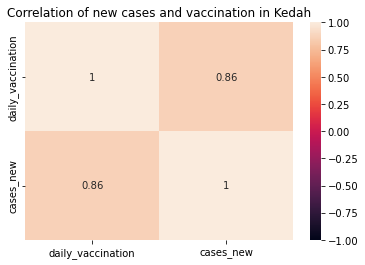

Kelantan



,date,daily_vaccination,cases_new
0,2021-03-10,0,19
1,2021-03-11,0,28
2,2021-03-12,0,43
3,2021-03-13,0,40
4,2021-03-14,162,26
...,...,...,...
199,2021-09-25,3865,1170
200,2021-09-26,7482,1206
201,2021-09-27,9445,983
202,2021-09-28,14057,1088


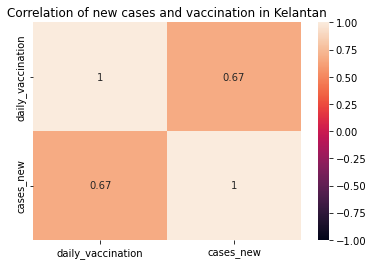

Melaka



,date,daily_vaccination,cases_new
0,2021-03-10,0,11
1,2021-03-11,0,71
2,2021-03-12,259,25
3,2021-03-13,16,2
4,2021-03-14,0,4
...,...,...,...
199,2021-09-25,11002,339
200,2021-09-26,2573,362
201,2021-09-27,4264,346
202,2021-09-28,4932,303


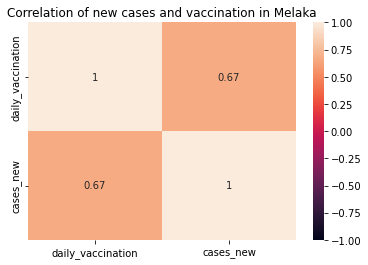

Negeri Sembilan



,date,daily_vaccination,cases_new
0,2021-03-10,0,10
1,2021-03-11,0,79
2,2021-03-12,0,32
3,2021-03-13,1,6
4,2021-03-14,0,21
...,...,...,...
199,2021-09-25,4820,194
200,2021-09-26,4771,165
201,2021-09-27,10034,110
202,2021-09-28,8787,89


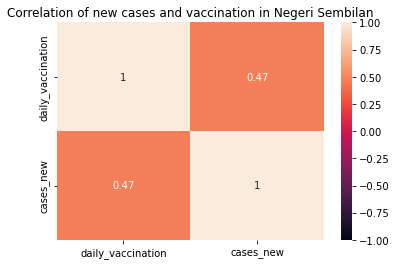

Pahang



,date,daily_vaccination,cases_new
0,2021-03-10,0,1
1,2021-03-11,122,7
2,2021-03-12,773,4
3,2021-03-13,1766,8
4,2021-03-14,100,5
...,...,...,...
199,2021-09-25,21882,779
200,2021-09-26,15379,604
201,2021-09-27,10204,739
202,2021-09-28,11271,677


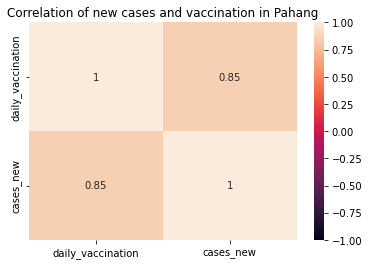

Perak



,date,daily_vaccination,cases_new
0,2021-03-10,0,83
1,2021-03-11,297,69
2,2021-03-12,579,44
3,2021-03-13,244,72
4,2021-03-14,134,101
...,...,...,...
199,2021-09-25,24120,1128
200,2021-09-26,18564,994
201,2021-09-27,27778,713
202,2021-09-28,28887,678


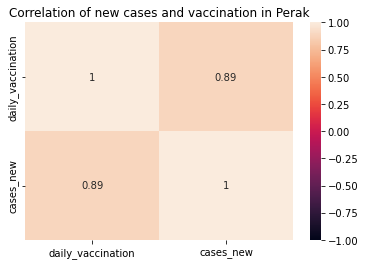

Perlis



,date,daily_vaccination,cases_new
0,2021-03-10,0,7
1,2021-03-11,0,2
2,2021-03-12,165,25
3,2021-03-13,3,29
4,2021-03-14,0,0
...,...,...,...
199,2021-09-25,1394,17
200,2021-09-26,1106,80
201,2021-09-27,3665,51
202,2021-09-28,5297,19


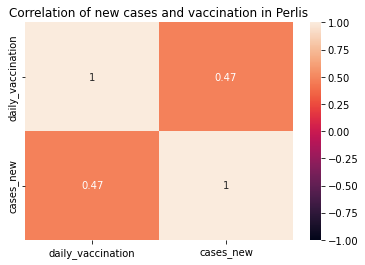

Pulau Pinang



,date,daily_vaccination,cases_new
0,2021-03-10,0,99
1,2021-03-11,0,169
2,2021-03-12,322,132
3,2021-03-13,6,178
4,2021-03-14,12,154
...,...,...,...
199,2021-09-25,20062,1060
200,2021-09-26,14976,955
201,2021-09-27,15450,793
202,2021-09-28,13544,895


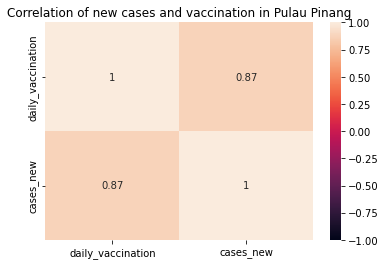

Sabah



,date,daily_vaccination,cases_new
0,2021-03-10,0,54
1,2021-03-11,1,61
2,2021-03-12,12,57
3,2021-03-13,563,71
4,2021-03-14,465,39
...,...,...,...
199,2021-09-25,28219,962
200,2021-09-26,26216,1078
201,2021-09-27,24091,751
202,2021-09-28,26483,965


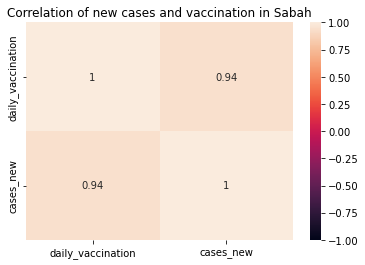

Sarawak



,date,daily_vaccination,cases_new
0,2021-03-10,1,199
1,2021-03-11,2,168
2,2021-03-12,1360,173
3,2021-03-13,3639,222
4,2021-03-14,3164,178
...,...,...,...
199,2021-09-25,22027,2712
200,2021-09-26,14443,2943
201,2021-09-27,4739,2723
202,2021-09-28,4191,2358


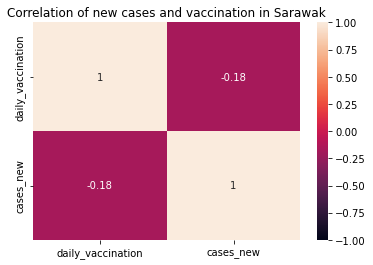

Selangor



,date,daily_vaccination,cases_new
0,2021-03-10,0,561
1,2021-03-11,43,712
2,2021-03-12,285,751
3,2021-03-13,79,551
4,2021-03-14,66,577
...,...,...,...
199,2021-09-25,23712,2341
200,2021-09-26,21291,1558
201,2021-09-27,21923,979
202,2021-09-28,18352,1231


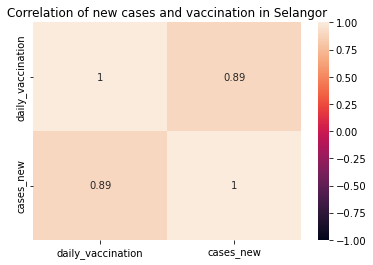

Terengganu



,date,daily_vaccination,cases_new
0,2021-03-10,0,8
1,2021-03-11,0,4
2,2021-03-12,11,16
3,2021-03-13,1,14
4,2021-03-14,472,37
...,...,...,...
199,2021-09-25,7665,760
200,2021-09-26,14403,685
201,2021-09-27,14415,691
202,2021-09-28,16975,629


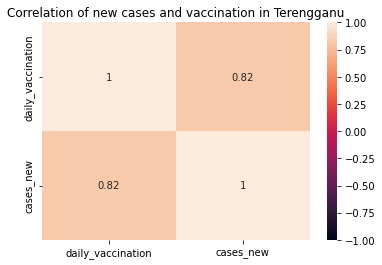

W.P. Kuala Lumpur



,date,daily_vaccination,cases_new
0,2021-03-10,41,103
1,2021-03-11,545,86
2,2021-03-12,325,108
3,2021-03-13,224,158
4,2021-03-14,150,55
...,...,...,...
199,2021-09-25,27802,310
200,2021-09-26,23622,270
201,2021-09-27,20374,176
202,2021-09-28,21305,240


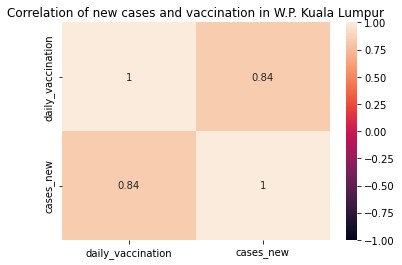

W.P. Labuan



,date,daily_vaccination,cases_new
0,2021-03-10,0,0
1,2021-03-11,2,1
2,2021-03-12,0,3
3,2021-03-13,136,1
4,2021-03-14,363,1
...,...,...,...
199,2021-09-25,1206,5
200,2021-09-26,983,4
201,2021-09-27,345,0
202,2021-09-28,190,3


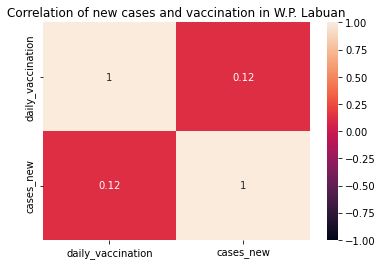

W.P. Putrajaya



,date,daily_vaccination,cases_new
0,2021-03-10,18,0
1,2021-03-11,55,2
2,2021-03-12,19,4
3,2021-03-13,6,4
4,2021-03-14,1,2
...,...,...,...
199,2021-09-25,0,37
200,2021-09-26,0,24
201,2021-09-27,935,18
202,2021-09-28,571,19


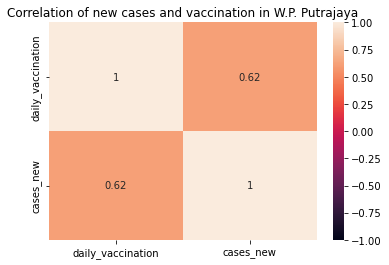

In [27]:
for state in total_states:
    q1(vax_state_df.copy(),cases_state_df.copy(),state)

# 2. Clustering states into green, yellow and red zones by looking at the daily new cases, death cases and vaccination rate. (Takes population into consideration)

In [28]:
def q2(vax_df,cases_df,deaths_df,pop_df,state):
    vax = vax_df[vax_df['state'] == state]
    cases = cases_df[cases_df['state'] == state]
    deaths = deaths_df[deaths_df['state'] == state]
    pop = pop_df[pop_df['state'] == state]
    
    total_new = cases['cases_new'].values.sum()
    total_recovered = cases['cases_recovered'].values.sum()
    total_deaths = deaths['deaths_new'].values.sum()
    total_vax = vax['cumul_vaccination'].values[-1]
    population = pop['pop'].values[0]
    
    active = total_new-total_recovered-total_deaths
    
    df = pd.DataFrame({'state':[state],
                      'active':[active/population*100],
                      'vaccination':[total_vax/population*100]})
    return df

In [29]:
q2_df = pd.DataFrame()

for state in total_states:
    q2_df = pd.concat([q2_df,q2(vax_state_df.copy(),cases_state_df.copy(),death_state_df.copy(),population_df.copy(),state)])
q2_df

,state,active,vaccination
0,Johor,0.541497,70.267628
0,Kedah,0.280628,64.269782
0,Kelantan,0.522264,56.082603
0,Melaka,0.457167,70.916479
0,Negeri Sembilan,0.153880,77.472183
0,Pahang,0.549413,64.015071
0,Perak,0.382265,66.016333
0,Perlis,0.306787,74.316202
0,Pulau Pinang,0.506540,76.558694
0,Sabah,0.386414,56.267392


,state,active,vaccination,zone
0,Johor,0.541497,70.267628,0
0,Kedah,0.280628,64.269782,0
0,Kelantan,0.522264,56.082603,0
0,Melaka,0.457167,70.916479,0
0,Negeri Sembilan,0.153880,77.472183,0
0,Pahang,0.549413,64.015071,0
0,Perak,0.382265,66.016333,0
0,Perlis,0.306787,74.316202,0
0,Pulau Pinang,0.506540,76.558694,0
0,Sabah,0.386414,56.267392,0


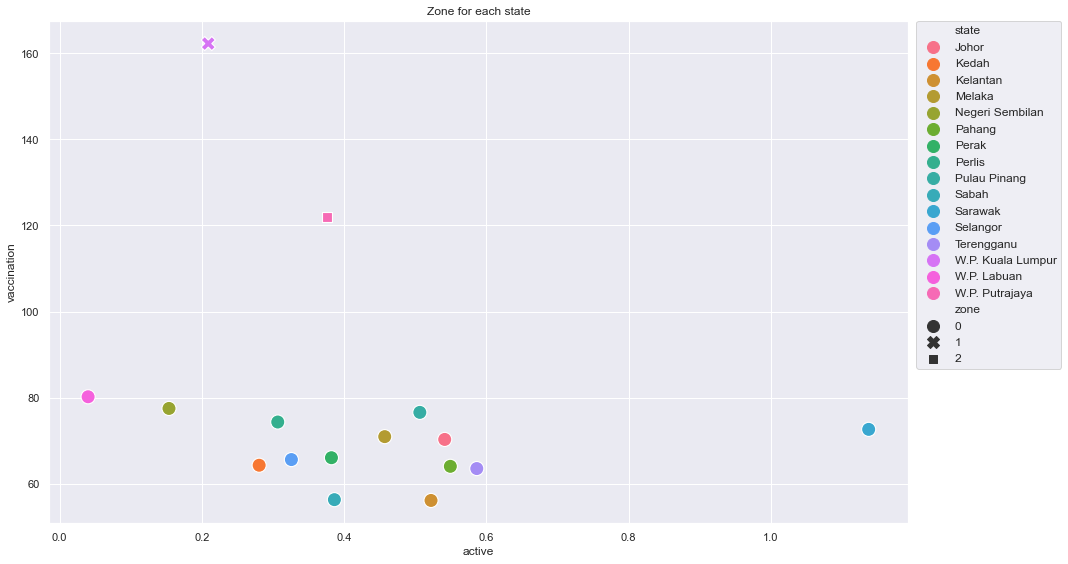

In [30]:
model = KMeans(n_clusters=3)
X = q2_df[['active','vaccination']].copy()

# fit the model
model.fit(X)

# assign a cluster to each example
cat = model.predict(X)

cat_q2_df = q2_df.copy()
cat_q2_df['zone'] = cat
display(cat_q2_df)

sns.set(rc={'figure.figsize':(15,8)})

sp2 = sns.scatterplot(data=cat_q2_df, x="active", y="vaccination",hue="state",style="zone",s=200)#,palette=''
sp2.legend(loc='upper left',bbox_to_anchor=(1.01, 1),fontsize='medium',borderaxespad=0,markerscale=2)

plt.title('Zone for each state')
plt.tight_layout()
plt.savefig('images/q2/2/zone.png')

plt.show()

# 3. What are the strong features to death cases for Selangor, Sarawak, Sabah and Johor?

In [27]:
def q3_df(used_df,state):
    cases = used_df[0][used_df[0]['state'] == state].drop('state',axis=1)
    death = used_df[1][used_df[1]['state'] == state].drop('state',axis=1)
    hospital = used_df[2][used_df[2]['state'] == state].drop('state',axis=1)
    icu = used_df[3][used_df[3]['state'] == state].drop('state',axis=1)
    pkrc = used_df[4][used_df[4]['state'] == state].drop('state',axis=1)
    vax = used_df[5][used_df[5]['state'] == state].drop(['state','cumul_vaccination'],axis=1)
    
    vax['effective_date'] = vax[['date']].shift(periods=-14)['date']
    vax = vax.drop('date',axis=1)
    vax = vax[['effective_date','daily_vaccination']].copy()
    vax.columns = ['date','daily_vaccination']
    vax = vax.dropna()
    
    combine = cases.merge(right=death, how="inner")
    combine = combine.merge(right=hospital, how="inner")
    combine = combine.merge(right=icu, how="inner")
    combine = combine.merge(right=pkrc, how="inner")
    combine = combine.merge(right=vax, how="inner")
    
    display(combine)

    return combine

In [28]:
selangor_df_q3 = q3_df(used_df.copy(),'Selangor')

,date,cases_new,cases_recovered,deaths_new,hospital_admitted_covid,hospital_discharged_covid,icu_covid,vent_covid,pkrc_admitted_covid,pkrc_discharged_covid,pkrc_covid,daily_vaccination
0,2021-03-10,561,472,2,67,71,55,31,561,406,3148,0
1,2021-03-11,712,746,4,57,90,52,32,349,517,2984,43
2,2021-03-12,751,802,1,75,71,48,31,419,622,2781,285
3,2021-03-13,551,719,1,76,93,46,26,408,446,2744,79
4,2021-03-14,577,576,1,58,77,48,29,204,573,2379,66
...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-09-25,2341,2345,75,140,127,171,100,289,305,2005,23712
200,2021-09-26,1558,2264,113,131,121,163,95,212,266,1940,21291
201,2021-09-27,979,1949,56,92,113,128,85,218,261,1909,21923
202,2021-09-28,1231,2629,41,116,125,161,89,234,287,1851,18352


In [29]:
sarawak_df_q3 = q3_df(used_df.copy(),'Sarawak')

,date,cases_new,cases_recovered,deaths_new,hospital_admitted_covid,hospital_discharged_covid,icu_covid,vent_covid,pkrc_admitted_covid,pkrc_discharged_covid,pkrc_covid,daily_vaccination
0,2021-03-10,199,154,0,280,109,42,16,38,35,1717,1
1,2021-03-11,168,262,0,123,258,44,14,82,18,1634,2
2,2021-03-12,173,233,0,145,173,45,16,30,33,1590,1360
3,2021-03-13,222,226,0,140,216,47,17,14,22,1518,3639
4,2021-03-14,178,168,1,174,131,47,18,35,34,1580,3164
...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-09-25,2712,3616,9,318,319,124,46,111,199,4432,22027
200,2021-09-26,2943,4752,11,342,269,124,43,268,362,4982,14443
201,2021-09-27,2723,3385,19,344,363,109,46,118,166,4293,4739
202,2021-09-28,2358,2145,15,329,222,114,45,130,132,4532,4191


In [30]:
sabah_df_q3 = q3_df(used_df.copy(),'Sabah')

,date,cases_new,cases_recovered,deaths_new,hospital_admitted_covid,hospital_discharged_covid,icu_covid,vent_covid,pkrc_admitted_covid,pkrc_discharged_covid,pkrc_covid,daily_vaccination
0,2021-03-10,54,57,1,23,16,19,7,43,42,374,0
1,2021-03-11,61,78,0,24,21,19,6,43,76,358,1
2,2021-03-12,57,88,1,19,24,15,6,31,59,330,12
3,2021-03-13,71,77,0,28,18,17,5,51,61,322,563
4,2021-03-14,39,158,0,34,11,15,6,29,63,290,465
...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-09-25,962,2433,19,131,96,133,54,293,347,2158,28219
200,2021-09-26,1078,3394,22,80,62,130,53,226,292,2100,26216
201,2021-09-27,751,1273,12,88,76,127,50,179,261,2011,24091
202,2021-09-28,965,1388,38,110,85,121,47,205,323,1880,26483


In [31]:
johor_df_q3 = q3_df(used_df.copy(),'Johor')

,date,cases_new,cases_recovered,deaths_new,hospital_admitted_covid,hospital_discharged_covid,icu_covid,vent_covid,pkrc_admitted_covid,pkrc_discharged_covid,pkrc_covid,daily_vaccination
0,2021-03-10,273,336,1,40,25,24,14,60,45,359,0
1,2021-03-11,170,218,2,37,28,23,17,23,54,360,79
2,2021-03-12,135,299,0,45,37,26,20,9,3,172,0
3,2021-03-13,101,328,0,28,31,25,20,25,75,328,2
4,2021-03-14,121,289,0,39,22,27,19,47,44,329,827
...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-09-25,1377,2057,56,167,213,87,58,182,228,1808,42688
200,2021-09-26,1455,1906,32,145,136,88,71,147,214,1733,42962
201,2021-09-27,1226,1794,53,153,214,86,72,143,150,1724,38553
202,2021-09-28,1319,1800,47,160,228,80,71,145,208,1659,46373


In [32]:
def q3_features(df,state):
    
    # Graph setting
    sns.set(rc={'figure.figsize':(12,10)})
    plt.figure(figsize=(12,10))
    
    # Get correlation matrix
    corr = df.corr()
    plt.subplot(211)
    plt.title('Heatmap of '+state)
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1)
    
    # mutual information
    x = df.drop(['date','cases_recovered'],axis=1)
    y = df['cases_recovered']
    importance = mutual_info_regression(x,y)
    importance_df = pd.DataFrame(x.columns,columns=['Feature'])
    importance_df['Importance'] = importance
    importance_df = importance_df.sort_values('Importance',ascending=False)

    # Plot the graph
    plt.subplot(212)
    plt.title("Importance of features for "+ state)
    barplot = sns.barplot(x="Feature", y="Importance", data=importance_df)
    for bar in barplot.patches:
        barplot.annotate(format(bar.get_height(), '.4f'),
                         (bar.get_x() + bar.get_width() / 2,bar.get_height()),
                         ha='center',
                         va='center',
                         fontsize=12,
                         xytext=(0, 8),
                         textcoords='offset points')
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.savefig('images/q2/3/'+state+'_features.png')
    plt.show()

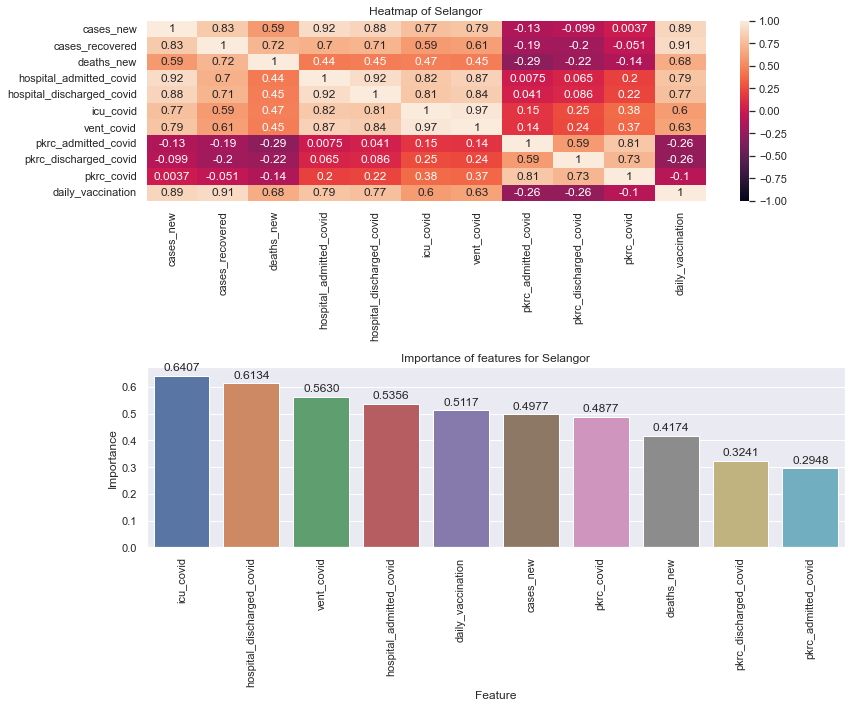

In [37]:
q3_features(selangor_df_q3.copy(),'Selangor')
# heatmap: cases_new,hospital_admitted_covid,hospital_discharged_covid,daily_vaccination
# mutual info(6): icu_covid,hospital_discharged_covid,vent_covid,hospital_admitted_covid,daily_vaccination,cases_new
# selected: cases_new,hospital_admitted_covid,hospital_discharged_covid,daily_vaccination

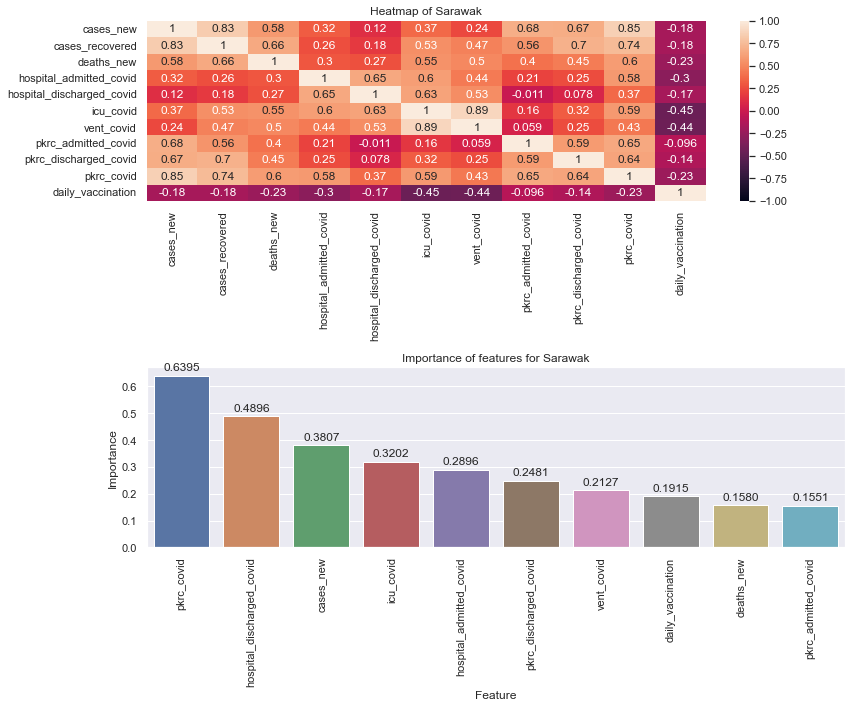

In [38]:
q3_features(sarawak_df_q3.copy(),'Sarawak')
# heatmap: cases_new,deaths_new,pkrc_discharged_covid,pkrc_covid
# mutual info(6): pkrc_covid,hospital_discharged_covid,cases_new,icu_covid,hospital_admitted_covid,pkrc_discharged_covid
# selected: cases_new,pkrc_discharged_covid,pkrc_covid (deaths_new not taken cuz in mutual info too weak)

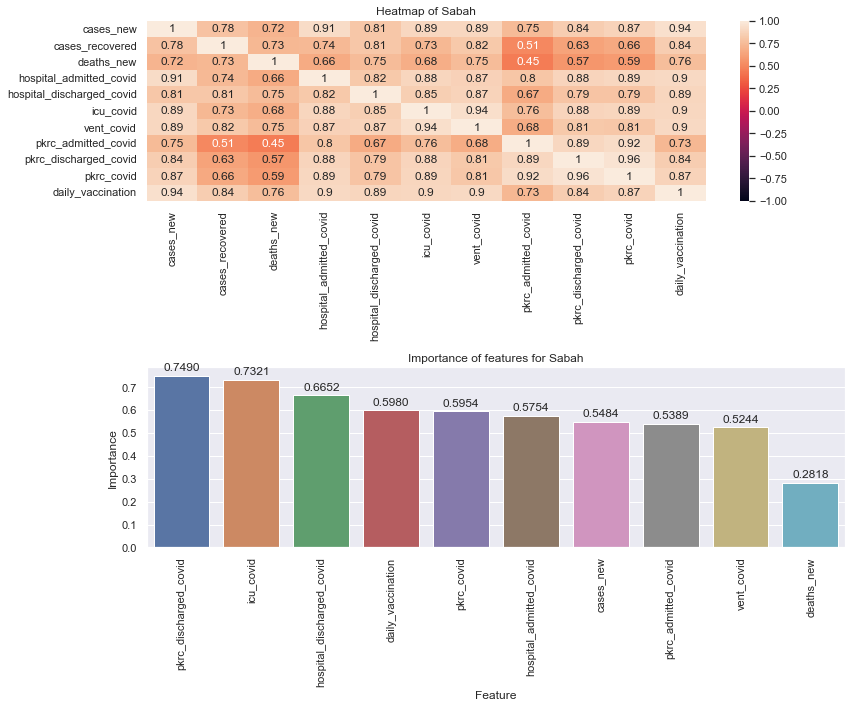

In [39]:
q3_features(sabah_df_q3.copy(),'Sabah')
# heatmap: cases_new,deaths_new,hospital_admitted_covid,hospital_discharged_covid,icu_covid,vent_covid,daily_vaccination
# mutual info(6): pkrc_discharged_covid,icu_covid,hospital_discharged_covid,pkrc_covid,daily_vaccination,hospital_admitted_covid
# selected: hospital_admitted_covid,hospital_discharged_covid,icu_covid,daily_vaccination

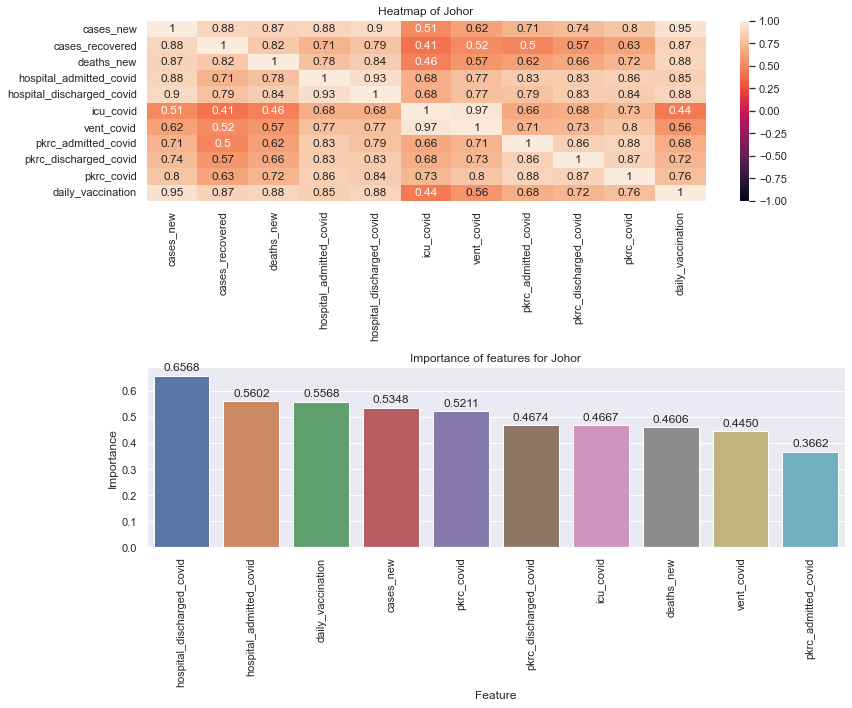

In [40]:
q3_features(johor_df_q3.copy(),'Johor')
# heatmap: cases_new,deaths_new,hospital_admitted_covid,hospital_discharged_covid,daily_vaccination
# mutual info: hospital_discharged_covid,daily_vaccination,hospital_admitted_covid,cases_new,pkrc_covid,icu_covid
# selected: cases_new,hospital_admitted_covid,hospital_discharged_covid,daily_vaccination

# 4. Is it possible to predict the recovered cases for Selangor, Sarawak, Sabah and Johor after the vaccination took place for two weeks? (daily new cases, hospital, icu cases and vaccination info) (2 regression models)

In [33]:
def best(x_train,y_train,x_test,y_test,state):
    score_list = []
    rmse_list = []
    y_pred_list = []
    
    for i in range(1,11):
        model = DecisionTreeRegressor(random_state = 0,max_depth=i)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        
        score = model.score(x_test,y_test)
        score_list.append(score)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        
        y_pred_list.append(y_pred)
    
    # Pick the max accuracy and min RMSE with min depth
    best_depth = np.argmax(score_list)+1
    lowest_rmse = rmse_list[np.argmax(score_list)]
    
    return max(score_list),lowest_rmse

In [34]:
def q4(df,state,features):
    scaler = StandardScaler()

    # separate training set and testing set for regression models
    x = df[features]
    x = scaler.fit_transform(x)
    y = df['cases_recovered']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    acc = []
    rmse = []

    #rf
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_test)
    acc.append(rf.score(x_test,y_test))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    # dtr
    dtr_acc,dtr_rmse = best(x_train,y_train,x_test,y_test,state)
    acc.append(dtr_acc)
    rmse.append(dtr_rmse)
    
    # Create dataframe
    data = {"Model_type": ['RF','DTR'],
            "Accuracy": acc,
            "RMSE": rmse,
            "State":[state,state]}
    df = pd.DataFrame(data)
    
    return df

In [35]:
selangor_df_q4 = q4(selangor_df_q3.copy(),'Selangor',['cases_new','hospital_admitted_covid','hospital_discharged_covid','daily_vaccination'])
sarawak_df_q4 = q4(sarawak_df_q3.copy(),'Sarawak',['cases_new','pkrc_discharged_covid','pkrc_covid'])
sabah_df_q4 = q4(sabah_df_q3.copy(),'Sabah',['hospital_admitted_covid','hospital_discharged_covid','icu_covid','daily_vaccination'])
johor_df_q4 = q4(johor_df_q3.copy(),'Johor',['cases_new','hospital_admitted_covid','hospital_discharged_covid','daily_vaccination'])

# combine
df_q4_combine = pd.concat([selangor_df_q4,sarawak_df_q4])
df_q4_combine = pd.concat([df_q4_combine,sabah_df_q4])
df_q4_combine = pd.concat([df_q4_combine,johor_df_q4])
df_q4_combine

,Model_type,Accuracy,RMSE,State
0,RF,0.820007,958.106190,Selangor
1,DTR,0.788927,1037.535631,Selangor
0,RF,0.827729,278.422638,Sarawak
1,DTR,0.497122,475.696864,Sarawak
0,RF,0.592894,467.953093,Sabah
1,DTR,0.653666,431.614420,Sabah
0,RF,0.765871,250.229412,Johor
1,DTR,0.721984,272.675265,Johor


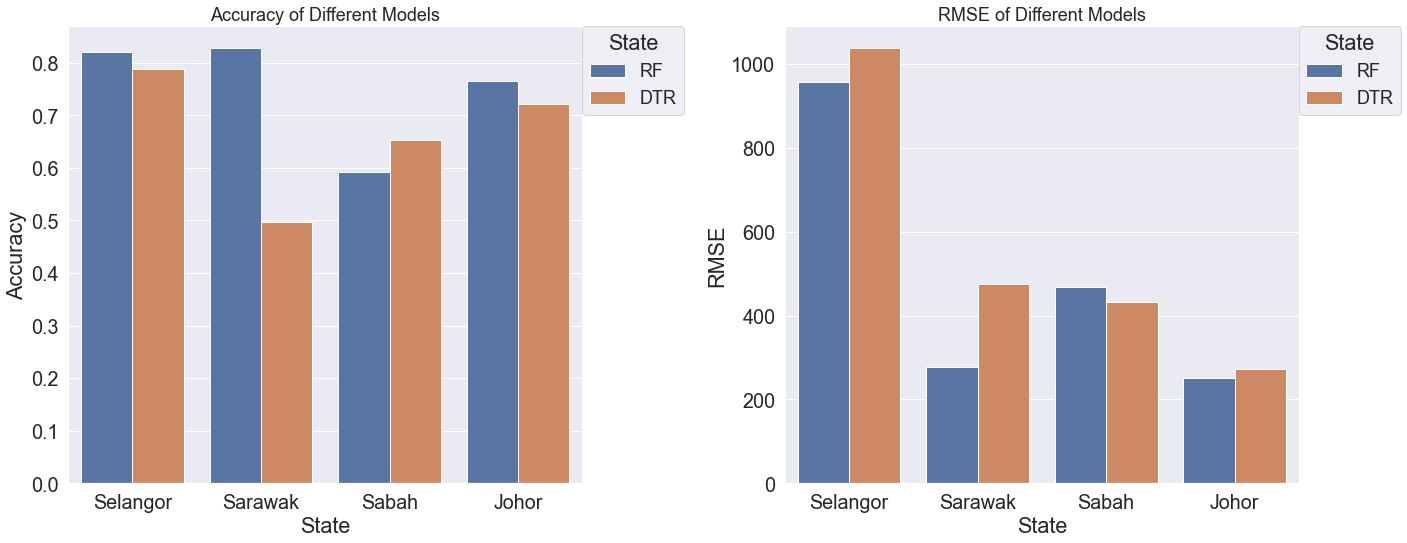

In [37]:
fig, ax = plt.subplots(figsize =(20, 8),nrows=1, ncols=2)
sns.set(font_scale = 1.8)

plt.subplot(121)
accuracy = sns.barplot(x="State",
            y="Accuracy",
            hue="Model_type",
            data=df_q4_combine)
accuracy.set_title("Accuracy of Different Models",fontsize=18)
accuracy.legend(loc='upper left',bbox_to_anchor=(1, 1),title='State',fontsize='small',borderaxespad=0)

plt.subplot(122)
accuracy = sns.barplot(x="State",
            y="RMSE",
            hue="Model_type",
            data=df_q4_combine)
accuracy.set_title("RMSE of Different Models",fontsize=18)
accuracy.legend(loc='upper left',bbox_to_anchor=(1, 1),title='State',fontsize='small',borderaxespad=0)

plt.tight_layout()
plt.savefig('images/q2/4/regression_result.png')
plt.show()

# 5. What are the features that are more relevant to being symptomatic to Covid-19?

In [46]:
x = positive_df.drop('symptomatic',axis=1)
y = positive_df['symptomatic']

colnames = x.columns

x = np.array(x)
y = np.array(y)

In [47]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(x, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=74, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x22623A18540),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x22623A18540, verbose=2)

In [48]:
dtc = DecisionTreeClassifier()
rfe = RFECV(dtc, step=1, verbose=2, cv=5)
rfe.fit(x, y)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator wi

RFECV(cv=5, estimator=DecisionTreeClassifier(), verbose=2)

In [49]:
feature_df = pd.DataFrame({'Features':colnames,'BORUTA_selected':feat_selector.support_,'RFE_selected':rfe.support_})
feature_df

,Features,BORUTA_selected,RFE_selected
0,import,True,False
1,cluster,True,True
2,state,True,False
3,district,True,True
4,age,True,True
5,male,True,False
6,malaysian,True,True


In [3]:
features = ['cluster','district','age','malaysian']

# 6. Is it possible to predict whether a person is showing the symptoms after he tested positive for Covid-19? (2 classification models)

In [7]:
def best(x_train,y_train,x_test,y_test):
    score_list = []
    
    for i in range(1,11):
        model = DecisionTreeClassifier(random_state = 0,max_depth=i)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        
        score = model.score(x_test,y_test)
        score_list.append(score)
        
    # Create dataframe
    data = {"Depth": np.arange(1,11),
            "Accuracy": score_list}
    df = pd.DataFrame(data)
    
    # Pick the max accuracy and min RMSE with min depth
    best_depth = np.argmax(score)+1
    
    return max(score_list),model

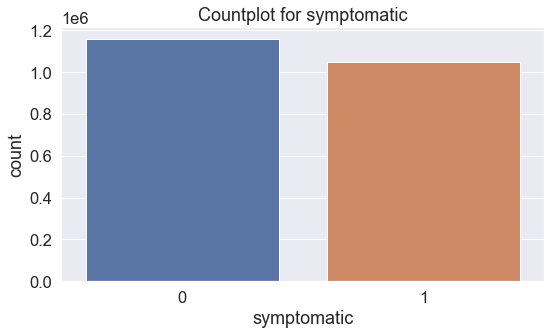

In [56]:
plt.figure(figsize=(8,5))
plt.title('Countplot for symptomatic')
sns.countplot(x ='symptomatic', data = positive_df)

plt.tight_layout()
plt.savefig('images/q2/6/countplot.png')
plt.show()

In [13]:
# separate training set and testing set for regression models
x = positive_df[features]
y = positive_df['symptomatic']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

#rf
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
rf_acc = rf.score(x_test, y_test)
print('Accuracy of RF:',rf_acc)

# dtr
dtc_acc,dtc = best(x_train,y_train,x_test,y_test)
y_pred_dtc = dtc.predict(x_test)
print('Accuracy of DTC:',dtc_acc)

Accuracy of RF: 0.6609842261857553
Accuracy of DTC: 0.6843514970507658


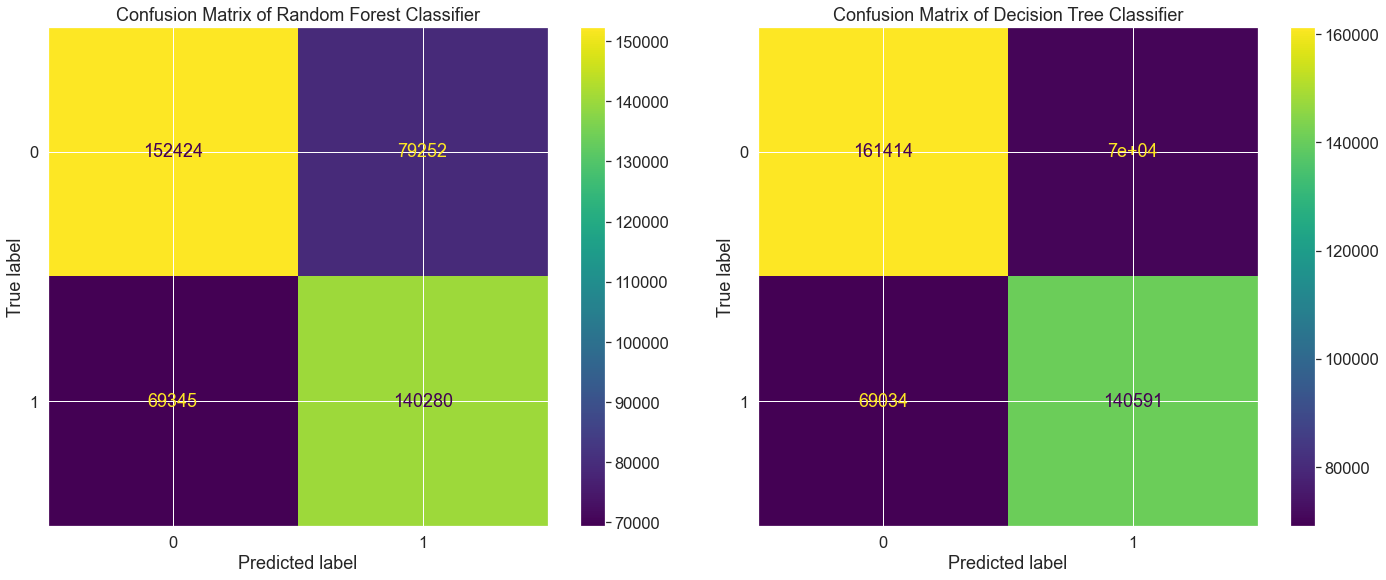

In [58]:
# confusion matrix
fig, ax = plt.subplots(figsize = (20, 8),nrows=1, ncols=2)

plt.subplot(121)
plt.title("Confusion Matrix of Random Forest Classifier")
plot_confusion_matrix(rf, x_test, y_test,ax=ax[0])

plt.subplot(122)
plt.title("Confusion Matrix of Decision Tree Classifier")
plot_confusion_matrix(dtc, x_test, y_test,ax=ax[1])

plt.tight_layout()
plt.savefig('images/q2/6/confusion_matrix.png')
plt.show()

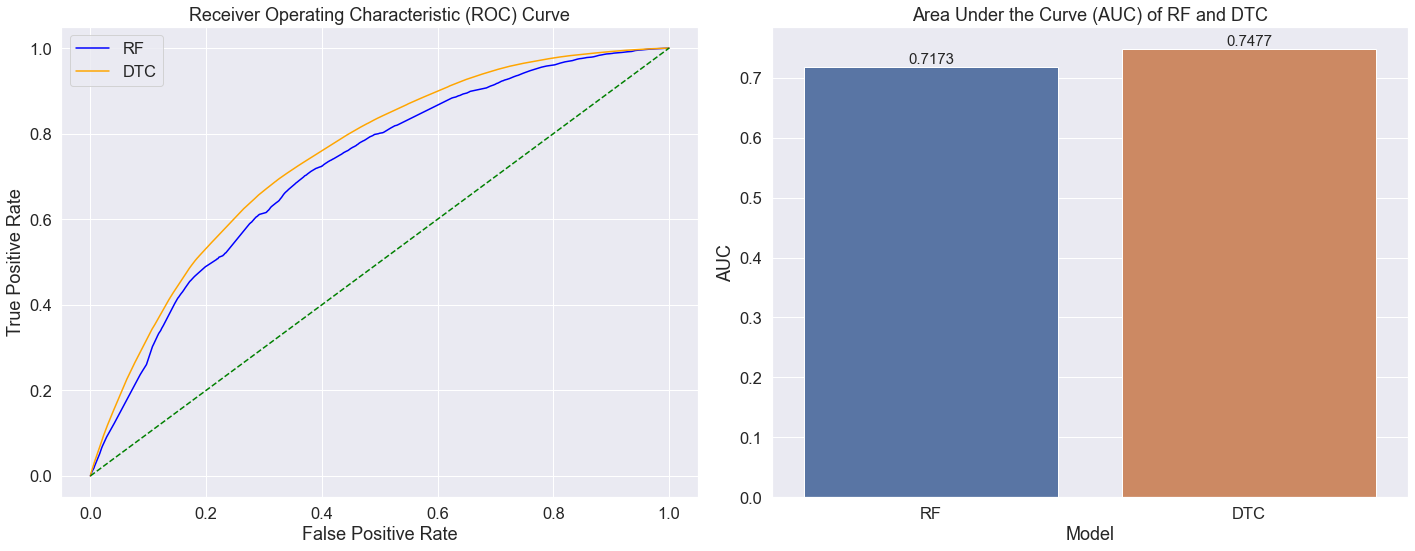

In [59]:
#ROC & AUC
fig, ax = plt.subplots(figsize = (20, 8),nrows=1, ncols=2)

prob_rf = rf.predict_proba(x_test)[:,1]
prob_dtc = dtc.predict_proba(x_test)[:,1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, prob_rf)
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_test, prob_dtc)

plt.subplot(121)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr_rf, tpr_rf, color='blue', label='RF') 
plt.plot(fpr_dtc, tpr_dtc, color='orange', label='DTC') 
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

models = ['RF','DTC']
auc = [roc_auc_score(y_test, prob_rf),roc_auc_score(y_test, prob_dtc)]
df = pd.DataFrame({'Model':models,'AUC':auc})

plt.subplot(122)
plt.title("Area Under the Curve (AUC) of RF and DTC")
barplot = sns.barplot(x="Model", y="AUC", data=df)
for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), '.4f'),
                     (bar.get_x() + bar.get_width() / 2,bar.get_height()),
                     ha='center',
                     va='center',
                     fontsize=15,
                     xytext=(0, 8),
                     textcoords='offset points')

plt.tight_layout()
plt.savefig('images/q2/6/roc_auc.png')
plt.show()

# 7. What is the probability of someone being brought-in-dead if they have comorbidities? (ARM)

In [60]:
bid_df = death_df[['bid', 'comorb']].copy()
bid_df

,bid,comorb
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
26678,0,1
26679,0,1
26680,1,1
26681,0,1


In [64]:
frequent_itemsets = apriori(bid_df, min_support=1/26683, use_colnames=True)#
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=1/26683)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bid),(comorb),0.201139,0.748529,0.115504,0.574250,0.767171,-0.035054,0.590654
1,(comorb),(bid),0.748529,0.201139,0.115504,0.154308,0.767171,-0.035054,0.944624


# 8. What is the probability of someone involved in a cluster if they are from Selangor? (ARM)

In [87]:
cases_df = positive_df[['cluster', 'state']].copy()
cases_df

,cluster,state
3,0,1
4,0,1
5,0,1
6,0,2
7,0,1
...,...,...
277560,0,16
277561,0,16
277562,0,16
277563,0,16


In [66]:
states_df = pd.read_csv('covid19-public-main/epidemic/linelist/param_geo.csv')
states_df = states_df[['state', 'idxs']]
states_df.drop_duplicates(inplace=True, ignore_index=True)
states_df

,state,idxs
0,Johor,1
1,Kedah,2
2,Kelantan,3
3,Melaka,4
4,Negeri Sembilan,5
5,Pahang,6
6,Pulau Pinang,7
7,Perak,8
8,Perlis,9
9,Selangor,10


In [88]:
cases_df = cases_df.merge(states_df, left_on='state', right_on='idxs')
cases_df.drop(['state_x', 'idxs'], axis=1, inplace=True)
cases_df.columns = ['cluster','selangor']

# replace the boolean value in selangor column
cases_df.loc[(cases_df.selangor != 'Selangor'), 'selangor'] = 0
cases_df.loc[(cases_df.selangor == 'Selangor'), 'selangor'] = 1
cases_df

,cluster,selangor
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2206500,0,0
2206501,0,0
2206502,0,0
2206503,0,0


In [90]:
frequent_itemsets = apriori(cases_df, min_support=1/2206505 , use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=1/2206505)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(selangor),(cluster),0.292911,0.196989,0.037943,0.129537,0.657583,-0.019758,0.922510
1,(cluster),(selangor),0.196989,0.292911,0.037943,0.192614,0.657583,-0.019758,0.875775


# 9. When will the 80% vaccination rate be achieved?

In [20]:
vax_df = pd.read_csv('citf-public-main/vaccination/vax_malaysia.csv')
vax_df = vax_df[['date','cumul_partial']].copy()
vax_df

,date,cumul_partial
0,2021-02-24,60
1,2021-02-25,1206
2,2021-02-26,5321
3,2021-02-27,12044
4,2021-02-28,18743
...,...,...
213,2021-09-25,22715503
214,2021-09-26,22834060
215,2021-09-27,23007292
216,2021-09-28,23178045


In [22]:
population_my = population_df.head(1)['pop'].values[0]
population_my

32657400

In [24]:
vax_df['rate'] = vax_df['cumul_partial']/population_my
vax_rate = vax_df[['rate']]
vax_rate

,rate
0,0.000002
1,0.000037
2,0.000163
3,0.000369
4,0.000574
...,...
213,0.695570
214,0.699200
215,0.704505
216,0.709733


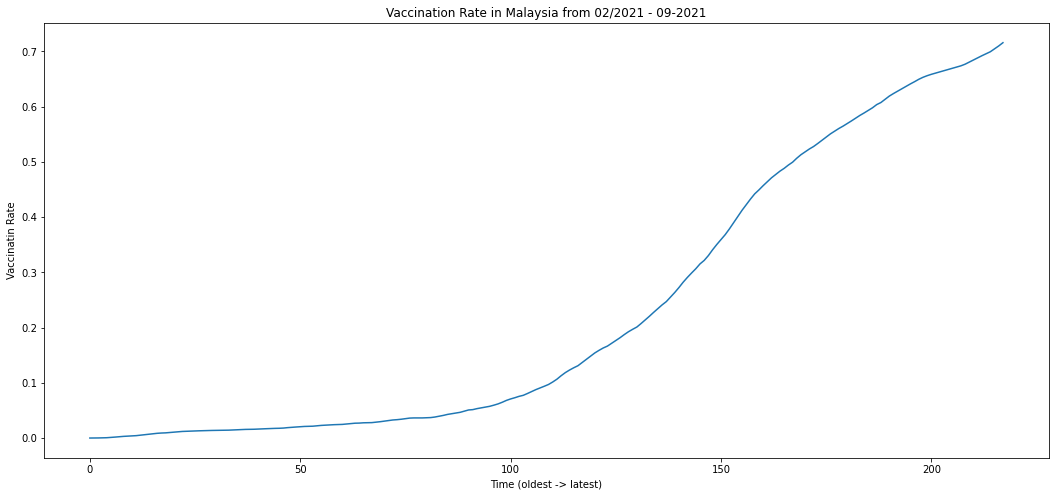

In [25]:
plt.figure(figsize=(18, 8))
plt.plot(vax_rate)
plt.title("Vaccination Rate in Malaysia from 02/2021 - 09-2021")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Vaccinatin Rate")
plt.show()

In [26]:
lookback = 30
total_size = len(vax_rate)

X=[]
y=[]
for i in range(0, total_size-lookback): # loop data set with margin 60 as we use 60 days data for prediction
    t=[]
    for j in range(0, lookback): # loop for 60 days
        current_index = i+j
        t.append(vax_rate.iloc[current_index].values[0]) # get data margin from 60 days
    X.append(t)
    y.append(vax_rate.iloc[lookback+i].values[0])

In [27]:
X_train = X[:len(X)-lookback]
y_train = y[:len(X)-lookback]

X_test = X[-lookback:]
y_test = y[-lookback:]

In [28]:
len(X_train),len(X_test)

(158, 30)

In [29]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [30]:
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))

X_train.shape,X_test.shape

((158, 30, 1), (30, 30, 1))

In [48]:
regressor = Sequential()

#add 1st lstm layer
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (lookback,1)))
regressor.add(Dropout(rate = 0.2))

regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [49]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

callbacks = [
    EarlyStopping(patience=10, verbose=1,monitor='loss'),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1,monitor='loss'),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True,monitor='loss')
]

In [50]:
history = regressor.fit(X_train, y_train, batch_size=200, epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.0702
Epoch 00001: loss improved from inf to 0.07015, saving model to model.h5
1/1 [==============================] - 0s 153ms/step - loss: 0.0702 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0436
Epoch 00002: loss improved from 0.07015 to 0.04359, saving model to model.h5
1/1 [==============================] - 0s 81ms/step - loss: 0.0436 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00003: loss improved from 0.04359 to 0.02311, saving model to model.h5
1/1 [==============================] - 0s 96ms/step - loss: 0.0231 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00004: loss improved from 0.02311 to 0.00849, saving model to model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.0085 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.0055
Epoch

In [51]:
y_pred = regressor.predict(X_test)

loss = regressor.evaluate(X_test,y_test)
loss

1/1 [==============================] - 0s 996us/step - loss: 5.2290e-05


5.228970621828921e-05

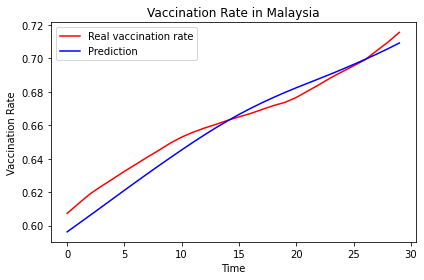

In [59]:
#visualize the prediction and real price
plt.plot(y_test, color = 'red', label = 'Real vaccination rate')
plt.plot(y_pred, color = 'blue', label = 'Prediction')

plt.title('Vaccination Rate in Malaysia')
plt.xlabel('Time')
plt.ylabel('Vaccination Rate')
plt.legend()
plt.tight_layout()
plt.savefig('images/q2/9/test_vaccination.png')
plt.show()

In [53]:
def predict(num_prediction):
    prediction_list = vax_rate[-lookback:]
    
    for _ in range(num_prediction):
        x = prediction_list[-lookback:]
        x = np.array(x)
        x = x.reshape((1, lookback, 1))
        out = regressor.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[lookback:]
        
    return prediction_list

In [54]:
predict_for = 60
forecast = predict(predict_for)
len(forecast)

60

In [55]:
labels = []
i = 0
while (i <= 1):
    labels.append(i)
    i += 0.1

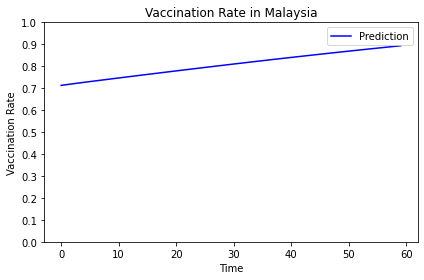

In [60]:
#visualize the prediction and real price
plt.plot(forecast, color = 'blue', label = 'Prediction')

plt.title('Vaccination Rate in Malaysia')
plt.xlabel('Time')
plt.ylabel('Vaccination Rate')
plt.yticks(labels)
plt.legend()
plt.tight_layout()
plt.savefig('images/q2/9/forecast_vaccination.png')
plt.show()

In [58]:
print('Possible vaccination rate around 1 November:',np.interp(30, range(predict_for),forecast))

Possible vaccination rate around 1 November: 0.8103079199790955
